## How much tracer is there on the shelf?

This notebook explores the effects of changing the initial tracer profile on the total amount of tracer (mass) on the shelf at a certain time and place.

In [1]:
#import gsw as sw # Gibbs seawater package

from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

#from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pandas as pd

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
lib_path = os.path.abspath('../BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts

sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 


In [3]:
sns.set()
sns.set_style('darkgrid')
sns.set_context('talk')

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
#Exp
CGrid = '/Users/Karina/Research/PhD/Tracers/TemporaryData/BARKLEY/run01/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
#CGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
CGridOut = Dataset(CGrid)


In [5]:
# General input

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
numTr = 8 # number of tracers in run

rc = CGridOut.variables['RC']

xc = rout.getField(CGrid, 'XC') # x coords tracer cells
yc = rout.getField(CGrid, 'YC') # y coords tracer cells

drF = CGridOut.variables['drF'] # vertical distance between faces
drC = CGridOut.variables['drC'] # vertical distance between centers

labels = ['Linear','Salt','Oxygen','Nitrate','Silicate','Phosphate','Nit. Acid','Methane']

#print(drC[:])
#print(np.shape(drC))

In [6]:
def get_iniProfile(exp, run, TrNum, key):
    '''Get column from the pandas dataframe containing initial profiles using the key name, run (01, 02, etc) and experiment 
    abreviated name (BAR, CNTDIFF, 3DDIFF, NOGMREDI), TrNum (1,2,3, etc). All input variables are strings.
    Returns the desired column from the dataframe.'''
    df = pd.read_csv(('results/metricsDataFrames/%srun%siniTr%s.csv' %(exp,run,TrNum)))
    col = df[key]
    return col

def get_metrics(exp, run, TrNum, key):
    '''Get column from a tracer metrics pandas dataframe using the key name, run (01, 02, etc) and experiment 
    abreviated name (BAR, CNTDIFF, 3DDIFF, NOGMREDI). All input variables are strings. Returns the desired column from the dataframe'''
    df = pd.read_csv(('results/metricsDataFrames/%srun%sTr%s.csv' %(exp,run,TrNum)))
    col = df[key]
    return col


In [7]:
# load initial profiles

tracers = ['1','2','3','4','5','6','7','8']

IniP = np.zeros((nz,len(tracers))) 
TotalTr = np.zeros((nt,len(tracers))) 
TotalHCW = np.zeros((nt,len(tracers)))
TotalTrNoC = np.zeros((nt,len(tracers))) 
TotalHCWNoC = np.zeros((nt,len(tracers))) 
TotalTrHole = np.zeros((nt,len(tracers))) 
TotalHCWHole = np.zeros((nt,len(tracers)))
TotalTrHoleNoC = np.zeros((nt,len(tracers))) 
TotalHCWHoleNoC = np.zeros((nt,len(tracers))) 

TotalTrSh = np.zeros((nt,len(tracers))) 
TotalHCWSh = np.zeros((nt,len(tracers)))
TotalTrShNoC = np.zeros((nt,len(tracers))) 
TotalHCWShNoC = np.zeros((nt,len(tracers))) 

kk = 0

for ii in tracers:
    
    IniP[:,kk] = get_iniProfile('BAR', '01', ii,'IniProfile' )
    TotalTr[:,kk] = get_metrics('BAR_hole_', '01', ii,'TronShelfwHole' ) # Shelf box
    TotalHCW[:,kk] = get_metrics('BAR_hole_', '01', ii,'HCWonShelfwHole' ) 
    TotalTrHole[:,kk] = get_metrics('BAR_hole_', '01', ii,'TronHole' ) # Canyon box
    TotalHCWHole[:,kk] = get_metrics('BAR_hole_', '01', ii,'HCWonHole' )
    
    TotalTrSh[:,kk] = get_metrics('BAR', '01', ii,'TronShelf' ) # Complete shelf
    TotalHCWSh[:,kk] = get_metrics('BAR', '01', ii,'HCWonShelf' )
    
    TotalTrNoC[:,kk] = get_metrics('BAR_hole_', '02', ii,'TronShelfwHole' ) # Shelf box no canyon
    TotalHCWNoC[:,kk] = get_metrics('BAR_hole_', '02', ii,'HCWonShelfwHole' )
    TotalTrHoleNoC[:,kk] = get_metrics('BAR_hole_', '02', ii,'TronHole' ) # canyon box no canyon
    TotalHCWHoleNoC[:,kk] = get_metrics('BAR_hole_', '02', ii,'HCWonHole' )
    
    TotalTrShNoC[:,kk] = get_metrics('BAR', '02', ii,'TronShelf' ) # complete shelf no canyon
    TotalHCWShNoC[:,kk] = get_metrics('BAR', '02', ii,'HCWonShelf' )
    
    kk=kk+1

    

## Definition of shelf box and canyon box

The shelf box (or shelf) is defined here as a box constructed by the east, west, and north boundaries, and a wall that goes from surface to 152 m (shelf break z[30]) **MINUS** the canyon box. The canyon box is defined as the volume over the canyon, from surface to shelf break, encompassed by x[120], x[240], y[227], y[267]. The canyon box is the shaded area of the following figure and the shelf box the rest of the shelf (north of the 150 m isobath).

<img src="figs/CrossShelfPlanes.png">

### Tracer and water with concentration equal or higher than at SB on shelf (HCW)

Tracer mass normalized by initial mass on shelf box for each run. HCW normalized by shelf box volume. In the case of the canyon box, the volume is smaller for the no canyon case, since there is more land when the shelf is smooth. The volume is the initial volume of HCW for oxygen, since all the water on the shelf has an oxygen concentration higher than at SB because the profile decreases exponentially with depth.


In [8]:
# Define volume of shelf, shelf box and canyon box with and without canyon.

volCanyonBox = TotalHCWHole[0,2] 
volCanyonBoxNoC = TotalHCWHoleNoC[0,2]

volShelfBoxNoC = TotalHCWNoC[0,2]
volShelfBox = TotalHCW[0,2]

volShelfNoC = TotalHCWShNoC[0,2]
volShelf = TotalHCWSh[0,2]



## Canyon case

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


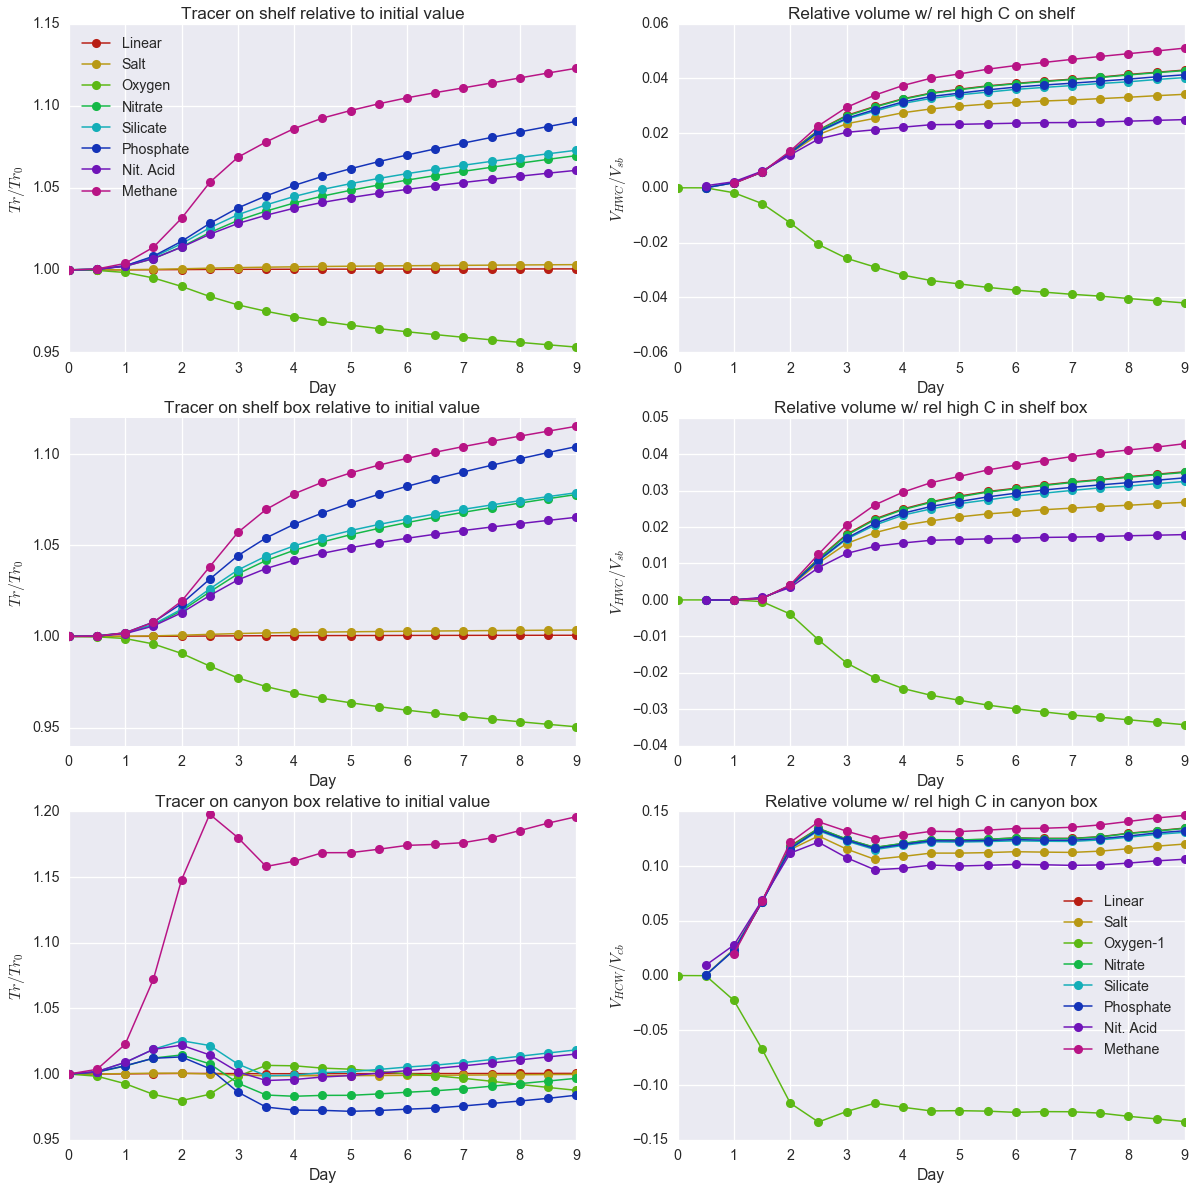

In [9]:
fig45=plt.figure(figsize=(20,20))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1.1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

sns.set_palette( sns.hls_palette(8, l=.4, s=.8))  

for tr in range(numTr):
    
    ax1 = plt.subplot(3,2,1)
    ax1.plot(times/2.0, TotalTrSh[:,tr]/TotalTrSh[0,tr],'o-', label=labels[tr])
    plt.ylabel('$Tr/Tr_0$ ')
    plt.xlabel('Day')
    plt.title('Tracer on shelf relative to initial value')

    
    ax2 = plt.subplot(3,2,3)
    ax2.plot(times/2.0, TotalTr[:,tr]/TotalTr[0,tr],'o-', label=labels[tr])
    plt.ylabel('$Tr/Tr_0$ ')
    plt.xlabel('Day')
    plt.title('Tracer on shelf box relative to initial value')

    ax3 = plt.subplot(3,2,5)
    ax3.plot(times/2.0, TotalTrHole[:,tr]/TotalTrHole[0,tr],'o-', label=labels[tr])
    plt.ylabel('$Tr / Tr_0$')
    plt.xlabel('Day')
    plt.title('Tracer on canyon box relative to initial value')

    
    ax4 = plt.subplot(3,2,2)
    if tr == 2:
        ax4.plot(times/2.0, (TotalHCWSh[:,tr]/volShelf)-1,'o-', label=('%s-1' %labels[tr] ))
    else:
        ax4.plot(times/2.0, (TotalHCWSh[:,tr]/volShelf),'o-', label=labels[tr])
    plt.title('Relative volume w/ rel high C on shelf')
    plt.ylabel('$V_{HWC}/V_{sb}$')
    plt.xlabel('Day')

    ax5 = plt.subplot(3,2,4)
    if tr == 2:
        ax5.plot(times/2.0, (TotalHCW[:,tr]/volShelfBox)-1,'o-', label=('%s-1' %labels[tr] ))
    else:
        ax5.plot(times/2.0, (TotalHCW[:,tr]/volShelfBox),'o-', label=labels[tr])
    plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('$V_{HWC}/V_{sb}$')
    plt.xlabel('Day')

    
    ax6 = plt.subplot(3,2,6)
    if tr == 2:
        ax6.plot(times/2.0, (TotalHCWHole[:,tr]/volCanyonBox)-1,'o-', label=('%s-1' %labels[tr] ))
    else:
        ax6.plot(times/2.0, (TotalHCWHole[:,tr]/volCanyonBox),'o-', label=labels[tr])
    plt.title('Relative volume w/ rel high C in canyon box')
    plt.ylabel('$V_{HCW}/ V_{cb}$')
    plt.xlabel('Day')

    

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax6.get_legend_handles_labels()
ax6.legend(handles, labels,loc=0)
   



#fig45.savefig('figures/TrOnShelfBoxBARrun01.eps', format='eps', dpi=1000, bbox_inches='tight')


  - Shelf: All tracers increase over the shelf throughout the simulation. Coastal upwelling signal is embedded in these plots. Max increase of approx 10% for methane (highest) and 5% for nitrous acid and less than 1% for linear and salt (lowest). Oxygen decreases, expected because profile dcreases with depth so upwelling brings low-oxygen water onto the shelf.

 - Shelf box: All tracers increase over the shelf box throughout the simulation. Coastal upwelling signal is embedded in these plots. Max increase of approx 10% for methane (highest) and 5% for nitrous acid and less than 1% for linear and salt (lowest). Oxygen decreases, expected because profile dcreases with depth so upwelling brings low-oxygen water onto the shelf. This signal dominates over the whole shelf (it's a larger region, obviously).

- Canyon box: Methane increases notoriously, compared to the other tracers, in the canyon box 20% compared to 2.5% during time dependent phase (or what looks like a time-dependent signal). After day 2.5 it decreases (to 15%) and starts increasing again for the rest of the simulation. The other tracers peak at day 2 (inverted peak for oxygen too), decrease and increase again after day 3.5. All tracers but methane decrease to have less tracer than initially and only nitrous acid and silicate recover. Nitrous acid and phosphate change roles. There there is more NA on shelf than Phosphate but it is the other way in the canyon box.
 
 
 - HCW behaves similarly for shelf and canyon boxes. There is a bit of a time dependent signal in the canyon box and higher percentage of volume filled with HCW. 
 
 - All time dependent signatures appear only in the canyon box quantities.

## No canyon case

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


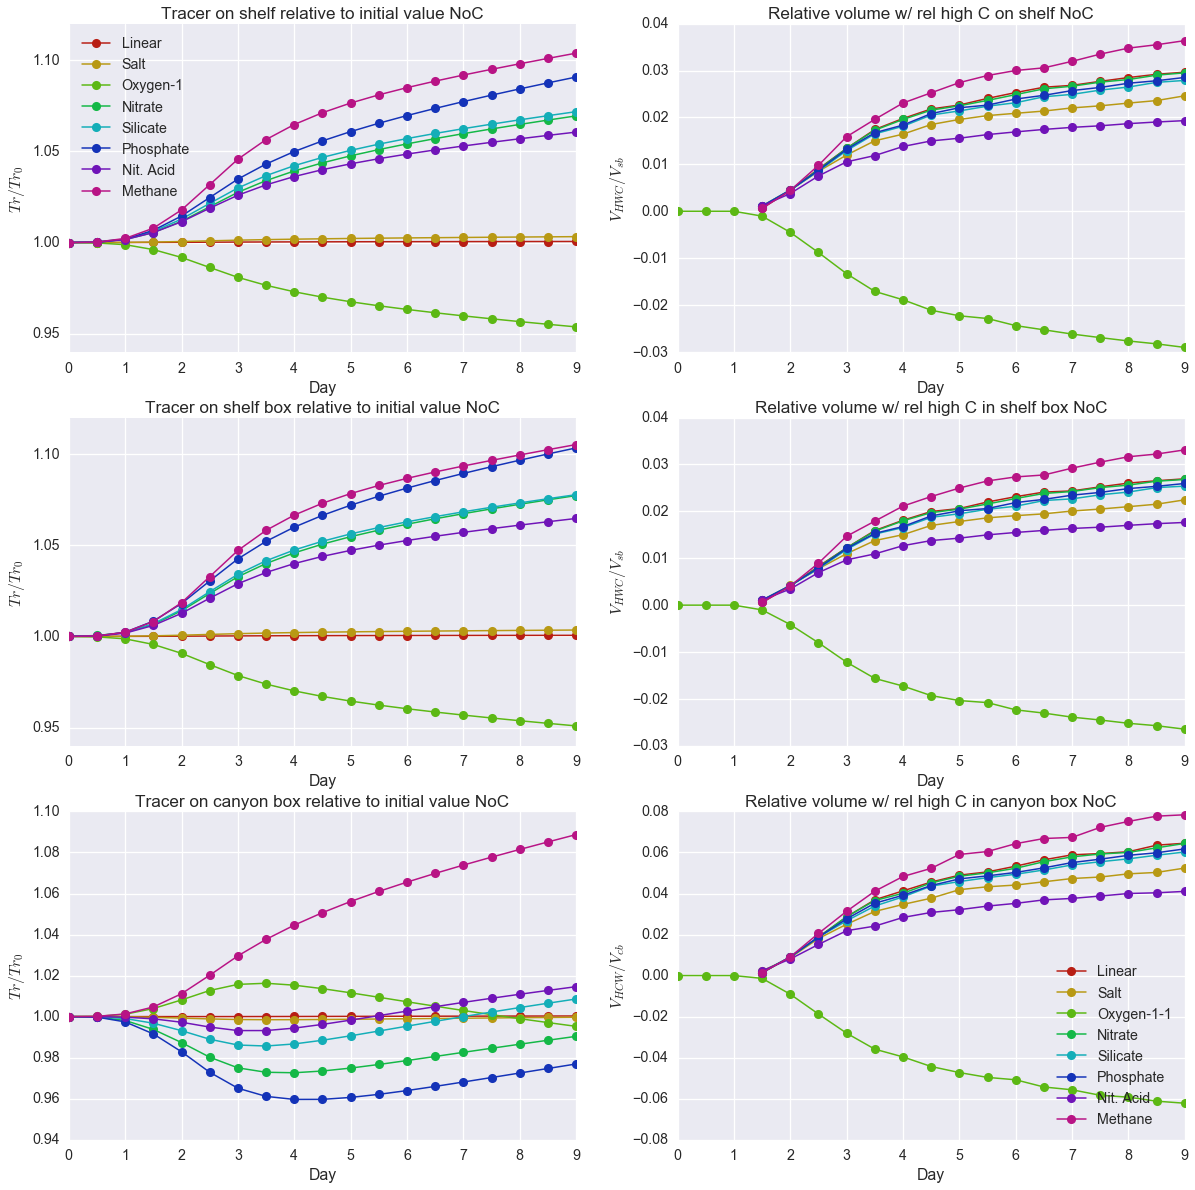

In [10]:
fig46=plt.figure(figsize=(20,20))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1.1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

sns.set_palette( sns.hls_palette(8, l=.4, s=.8))  

for tr in range(numTr):
    
    ax1 = plt.subplot(3,2,1)
    ax1.plot(times/2.0, TotalTrShNoC[:,tr]/TotalTrShNoC[0,tr],'o-', label=labels[tr])
    plt.ylabel('$Tr/Tr_0$ ')
    plt.xlabel('Day')
    plt.title('Tracer on shelf relative to initial value NoC')

    
    ax2 = plt.subplot(3,2,3)
    ax2.plot(times/2.0, TotalTrNoC[:,tr]/TotalTrNoC[0,tr],'o-', label=labels[tr])
    plt.ylabel('$Tr/Tr_0$ ')
    plt.xlabel('Day')
    plt.title('Tracer on shelf box relative to initial value NoC')

    ax3 = plt.subplot(3,2,5)
    ax3.plot(times/2.0, TotalTrHoleNoC[:,tr]/TotalTrHoleNoC[0,tr],'o-', label=labels[tr])
    plt.ylabel('$Tr / Tr_0$')
    plt.xlabel('Day')
    plt.title('Tracer on canyon box relative to initial value NoC')

    
    ax4 = plt.subplot(3,2,2)
    if tr == 2:
        ax4.plot(times/2.0, (TotalHCWShNoC[:,tr]/volShelfNoC)-1,'o-', label=('%s-1' %labels[tr] ))
    else:
        ax4.plot(times/2.0, (TotalHCWShNoC[:,tr]/volShelfNoC),'o-', label=labels[tr])
    plt.title('Relative volume w/ rel high C on shelf NoC')
    plt.ylabel('$V_{HWC}/V_{sb}$')
    plt.xlabel('Day')

    ax5 = plt.subplot(3,2,4)
    if tr == 2:
        ax5.plot(times/2.0, (TotalHCWNoC[:,tr]/volShelfBoxNoC)-1,'o-', label=('%s-1' %labels[tr] ))
    else:
        ax5.plot(times/2.0, (TotalHCWNoC[:,tr]/volShelfBoxNoC),'o-', label=labels[tr])
    plt.title('Relative volume w/ rel high C in shelf box NoC')
    plt.ylabel('$V_{HWC}/V_{sb}$')
    plt.xlabel('Day')

    
    ax6 = plt.subplot(3,2,6)
    if tr == 2:
        ax6.plot(times/2.0, (TotalHCWHoleNoC[:,tr]/volCanyonBoxNoC)-1,'o-', label=('%s-1' %labels[tr] ))
    else:
        ax6.plot(times/2.0, (TotalHCWHoleNoC[:,tr]/volCanyonBoxNoC),'o-', label=labels[tr])
    plt.title('Relative volume w/ rel high C in canyon box NoC')
    plt.ylabel('$V_{HCW}/ V_{cb}$')
    plt.xlabel('Day')

    

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax6.get_legend_handles_labels()
ax6.legend(handles, labels,loc=0)
   



#fig45.savefig('figures/TrOnShelfBoxBARrun01.eps', format='eps', dpi=1000, bbox_inches='tight')


I don't understand what is going on on the canyon box! All tracers decrease there without a canyon, why? The keep the same order as in the shelf box case, except for methane that should be the one that dcreases the most if they are to follow the order on the first plot. HCW is consistent in both plots.

The effect is very small though...

## Canyon effect

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


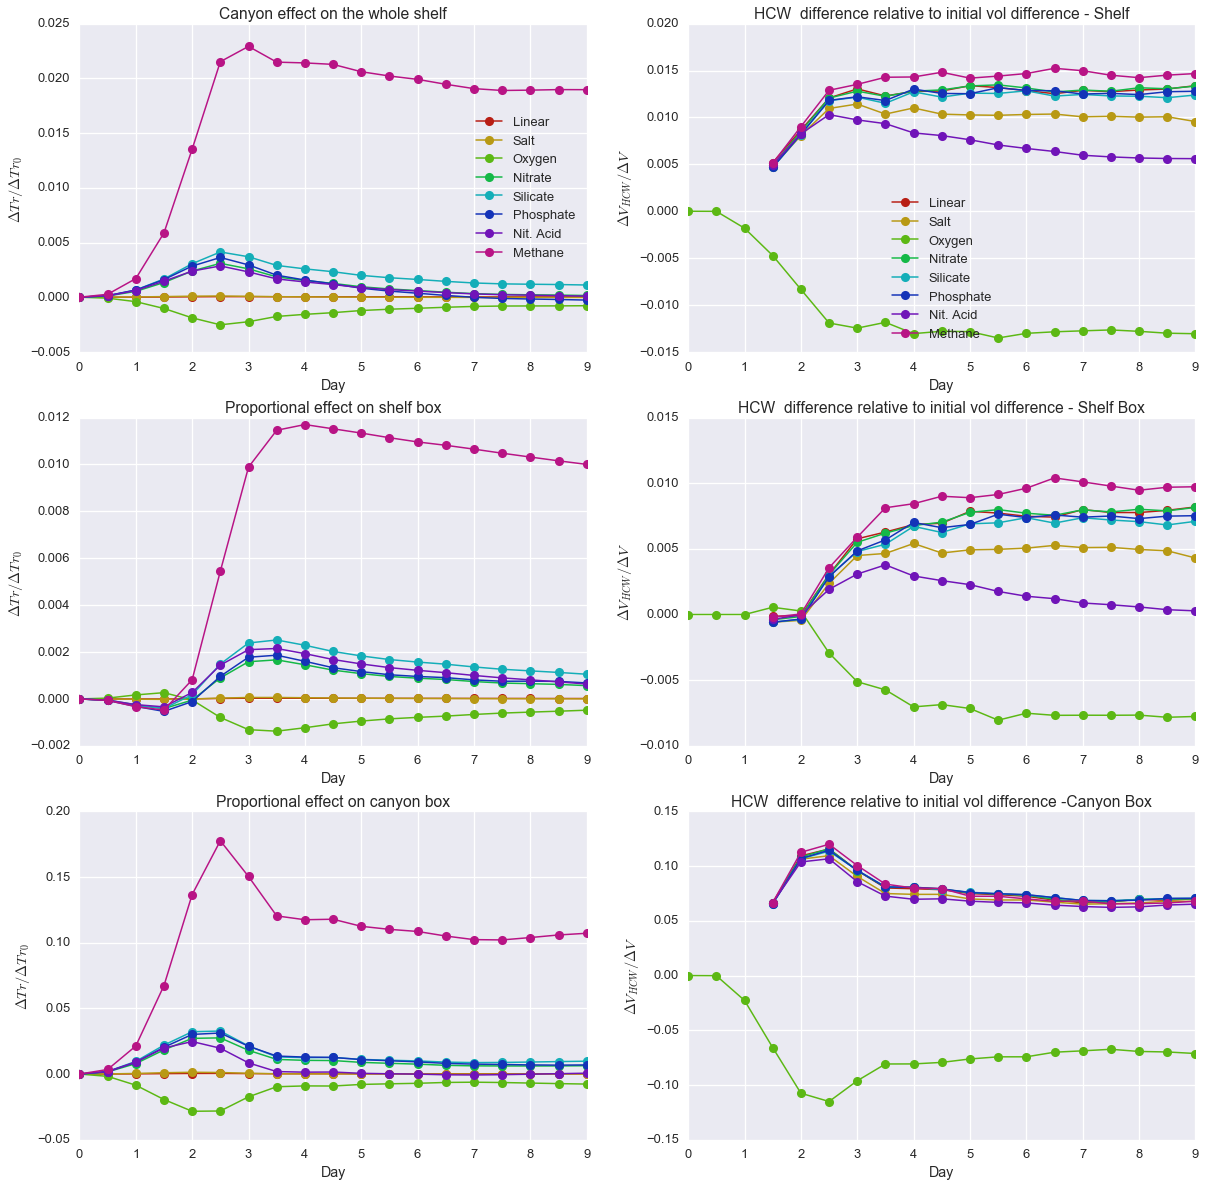

In [11]:
fig45=plt.figure(figsize=(20,20))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

sns.set_palette( sns.hls_palette(8, l=.4, s=.8))  

labels = ['Linear','Salt','Oxygen','Nitrate','Silicate','Phosphate','Nit. Acid','Methane']

for tr in range(numTr):
    
    ax1 = plt.subplot(3,2,1)
    ax1.plot(times/2.0, (TotalTrSh[:,tr]/TotalTrSh[0,tr])-(TotalTrShNoC[:,tr]/TotalTrShNoC[0,tr]),'o-', label=labels[tr])
    plt.ylabel('$\Delta Tr/\Delta Tr_0$ ')
    plt.xlabel('Day')
    plt.title('Canyon effect on the whole shelf')

    ax3 = plt.subplot(3,2,3)
    ax3.plot(times/2.0, (TotalTr[:,tr]/TotalTr[0,tr])-(TotalTrNoC[:,tr]/TotalTrNoC[0,tr]),'o-', label=labels[tr])
    plt.ylabel('$\Delta Tr/\Delta Tr_0$ ')
    plt.xlabel('Day')
    plt.title('Proportional effect on shelf box')

    ax5 = plt.subplot(3,2,5)
    ax5.plot(times/2.0, (TotalTrHole[:,tr]/TotalTrHole[0,tr])-(TotalTrHoleNoC[:,tr]/TotalTrHoleNoC[0,tr]),'o-', label=labels[tr])
    plt.ylabel('$\Delta Tr/\Delta Tr_0$ ')
    plt.xlabel('Day')
    plt.title('Proportional effect on canyon box')

    ax2 = plt.subplot(3,2,2)
    ax2.plot(times/2.0, (TotalHCWSh[:,tr]/volShelf)-(TotalHCWShNoC[:,tr]/volShelfNoC),'o-', label=labels[tr])
    plt.title('HCW  difference relative to initial vol difference - Shelf')
    plt.ylabel('$\Delta V_{HCW}/\Delta V$')
    plt.xlabel('Day')

    ax4 = plt.subplot(3,2,4)
    ax4.plot(times/2.0, (TotalHCW[:,tr]/volShelfBox)-(TotalHCWNoC[:,tr]/volShelfBoxNoC),'o-', label=labels[tr])
    plt.title('HCW  difference relative to initial vol difference - Shelf Box')
    plt.ylabel('$\Delta V_{HCW}/\Delta V$')
    plt.xlabel('Day')
    
    ax6 = plt.subplot(3,2,6)
    ax6.plot(times/2.0, (TotalHCWHole[:,tr]/volCanyonBox)-(TotalHCWHoleNoC[:,tr]/volCanyonBoxNoC),'o-', label=labels[tr])
    plt.title('HCW  difference relative to initial vol difference -Canyon Box')
    plt.ylabel('$\Delta V_{HCW}/\Delta V$')
    plt.xlabel('Day')
    
    

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)

   



#fig45.savefig('figures/TrOnShelfBoxBARrun02.eps', format='eps', dpi=1000, bbox_inches='tight')

        

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


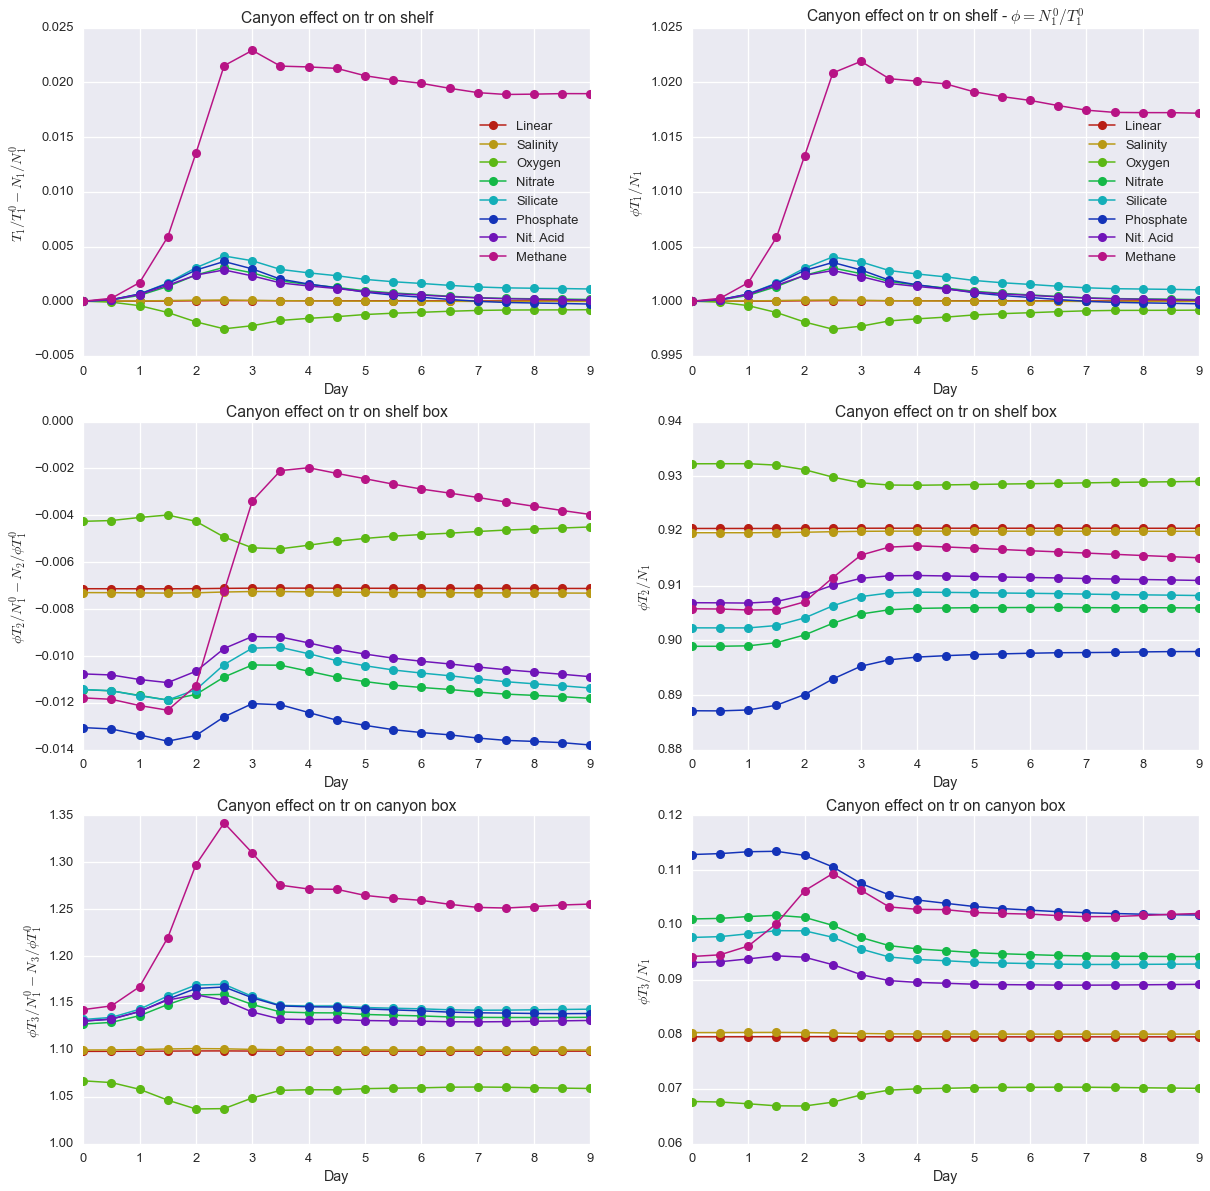

In [12]:
fig45=plt.figure(figsize=(20,20))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

sns.set_palette( sns.hls_palette(8, l=.4, s=.8))  

labels = ['Linear','Salinity','Oxygen','Nitrate','Silicate','Phosphate','Nit. Acid','Methane']

for tr in range(numTr):
    
    ax1 = plt.subplot(3,2,1)
    ax1.plot(times/2.0, (TotalTrSh[:,tr]/TotalTrSh[0,tr])-(TotalTrShNoC[:,tr]/TotalTrShNoC[0,tr]),'o-', label=labels[tr])
    plt.ylabel('$T_1/T_1^0-N_1/N_1^0$ ')
    plt.xlabel('Day')
    plt.title('Canyon effect on tr on shelf')

    ax3 = plt.subplot(3,2,3)
    ax3.plot(times/2.0, (TotalTr[:,tr]/TotalTrSh[0,tr])-(TotalTrNoC[:,tr]/TotalTrShNoC[0,tr]),'o-', label=labels[tr])
    plt.ylabel('$ \phi T_2/N_1^0-N_2/\phi T_1^0 $ ')
    plt.xlabel('Day')
    plt.title('Canyon effect on tr on shelf box')

    ax5 = plt.subplot(3,2,5)
    ax5.plot(times/2.0, (TotalTrHole[:,tr]/TotalTrSh[0,tr])/(TotalTrHoleNoC[:,tr]/TotalTrShNoC[0,tr]),'o-', label=labels[tr])
    plt.ylabel('$\phi T_3/N_1^0-N_3/\phi T_1^0 $ ')
    plt.xlabel('Day')
    plt.title('Canyon effect on tr on canyon box')

    ax2 = plt.subplot(3,2,2)
    ax2.plot(times/2.0, (TotalTrSh[:,tr]/TotalTrSh[0,tr])/(TotalTrShNoC[:,tr]/TotalTrShNoC[0,tr]) ,'o-', label=labels[tr])
    plt.ylabel('$\phi T_1/N_1$ ')
    plt.xlabel('Day')
    plt.title('Canyon effect on tr on shelf - $\phi = N_1^0/T_1^0$')

    ax4 = plt.subplot(3,2,4)
    ax4.plot(times/2.0, (TotalTrShNoC[0,tr]/TotalTrSh[0,tr])*(TotalTr[:,tr]/TotalTrShNoC[:,tr]),'o-', label=labels[tr])
    plt.ylabel('$\phi T_2/N_1$ ')
    plt.xlabel('Day')
    plt.title('Canyon effect on tr on shelf box')

    ax6 = plt.subplot(3,2,6)
    ax6.plot(times/2.0, (TotalTrShNoC[0,tr]/TotalTrSh[0,tr])*(TotalTrHole[:,tr]/TotalTrShNoC[:,tr]),'o-', label=labels[tr])
    plt.ylabel('$\phi T_3/N_1$ ')
    plt.xlabel('Day')
    plt.title('Canyon effect on tr on canyon box')
    
    

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
#handles, labels = ax2.get_legend_handles_labels()
#ax2.legend(handles, labels,loc=0)

   



#fig45.savefig('figures/TrOnShelfBoxBARrun02.eps', format='eps', dpi=1000, bbox_inches='tight')

        

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


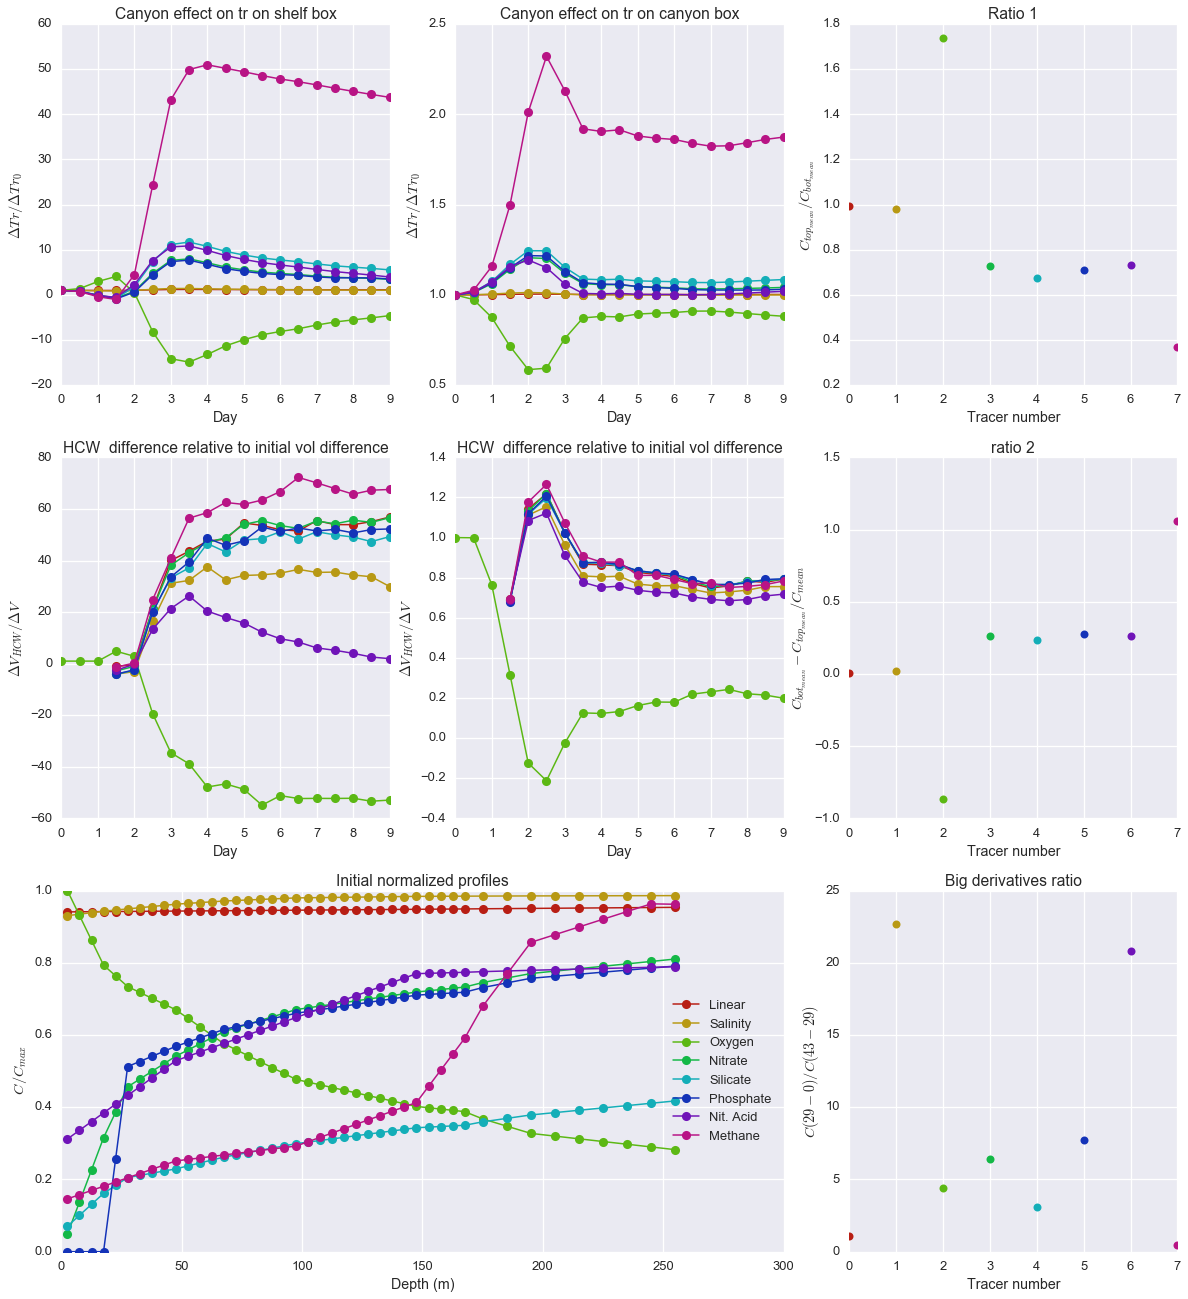

In [13]:
fig45=plt.figure(figsize=(20,22))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

sns.set_palette( sns.hls_palette(8, l=.4, s=.8))  

for tr in range(numTr):
    
    ax1 = plt.subplot(3,3,1)
    ax1.plot(times/2.0, (TotalTr[:,tr]-TotalTrNoC[:,tr])/(TotalTr[0,tr]-TotalTrNoC[0,tr]),'o-', label=labels[tr])
    plt.ylabel('$\Delta Tr/\Delta Tr_0$ ')
    plt.xlabel('Day')
    plt.title('Canyon effect on tr on shelf box')
    
    ax2 = plt.subplot(3,3,4)
    ax2.plot(times/2.0, (TotalHCW[:,tr]-TotalHCWNoC[:,tr])/(volShelfBox-volShelfBoxNoC),'o-', label=labels[tr])
    plt.title('HCW  difference relative to initial vol difference')
    plt.ylabel('$\Delta V_{HCW}/\Delta V$')
    plt.xlabel('Day')

    ax3 = plt.subplot(3,3,2)
    ax3.plot(times/2.0, (TotalTrHole[:,tr]-TotalTrHoleNoC[:,tr])/(TotalTrHole[0,tr]-TotalTrHoleNoC[0,tr]),'o-', label=labels[tr])
    plt.ylabel('$\Delta Tr/\Delta Tr_0$ ')
    plt.xlabel('Day')
    plt.title('Canyon effect on tr on canyon box')

    ax4 = plt.subplot(3,3,5)
    ax4.plot(times/2.0, (TotalHCWHole[:,tr]-TotalHCWHoleNoC[:,tr])/(volCanyonBox-volCanyonBoxNoC),'o-', label=labels[tr])
    plt.title('HCW  difference relative to initial vol difference')
    plt.ylabel('$\Delta V_{HCW}/\Delta V$')
    plt.xlabel('Day')

    
    ax5 = plt.subplot(3,3,(7,8))
    ax5.plot(-rc[0:43],IniP[0:43,tr]/np.max(IniP[:,tr]),'o-', label=labels[tr])
    plt.ylabel(' $C / C_{max}$')
    plt.xlabel('Depth (m)')
    plt.title('Initial normalized profiles')

    
    ax6 = plt.subplot(3,3,3)
    ax6.plot(tr,(np.mean(IniP[0:29,tr])/np.mean(IniP[29:43,tr])),'o',markersize = 8, label=labels[tr])
    plt.title('Ratio 1')
    #ax6.set_yscale('log')
    plt.ylabel('$C_{top_{mean}}/C_{bot_{mean}}$')
    plt.xlabel('Tracer number')
    
     
    ax7 = plt.subplot(3,3,9)
    ax7.plot(tr,(IniP[29,tr]-IniP[0,tr])/(IniP[43,tr]-IniP[29,tr]),'o',markersize = 8, label=labels[tr])
    plt.title('Big derivatives ratio')
    plt.ylabel('$C(29-0)/C(43-29)$')
    plt.xlabel('Tracer number')
    
    ax8 = plt.subplot(3,3,6)
    ax8.plot(tr,(-np.mean(IniP[0:29,tr])+np.mean(IniP[29:43,tr]))/np.mean(IniP[:,tr]),'o',markersize = 8, label=labels[tr])
    plt.title('ratio 2')
    #ax8.set_yscale('log')
    #plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    #plt.axhline(y=-225,linewidth=1, color='k', linestyle='-')
    
    plt.ylabel('$C_{bot_{mean}}-C_{top_{mean}}/C_{mean}$')
    plt.xlabel('Tracer number')
    
        
#plt.tight_layout()

handles, labels = ax5.get_legend_handles_labels()
ax5.legend(handles, labels,loc=0)



#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')


/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


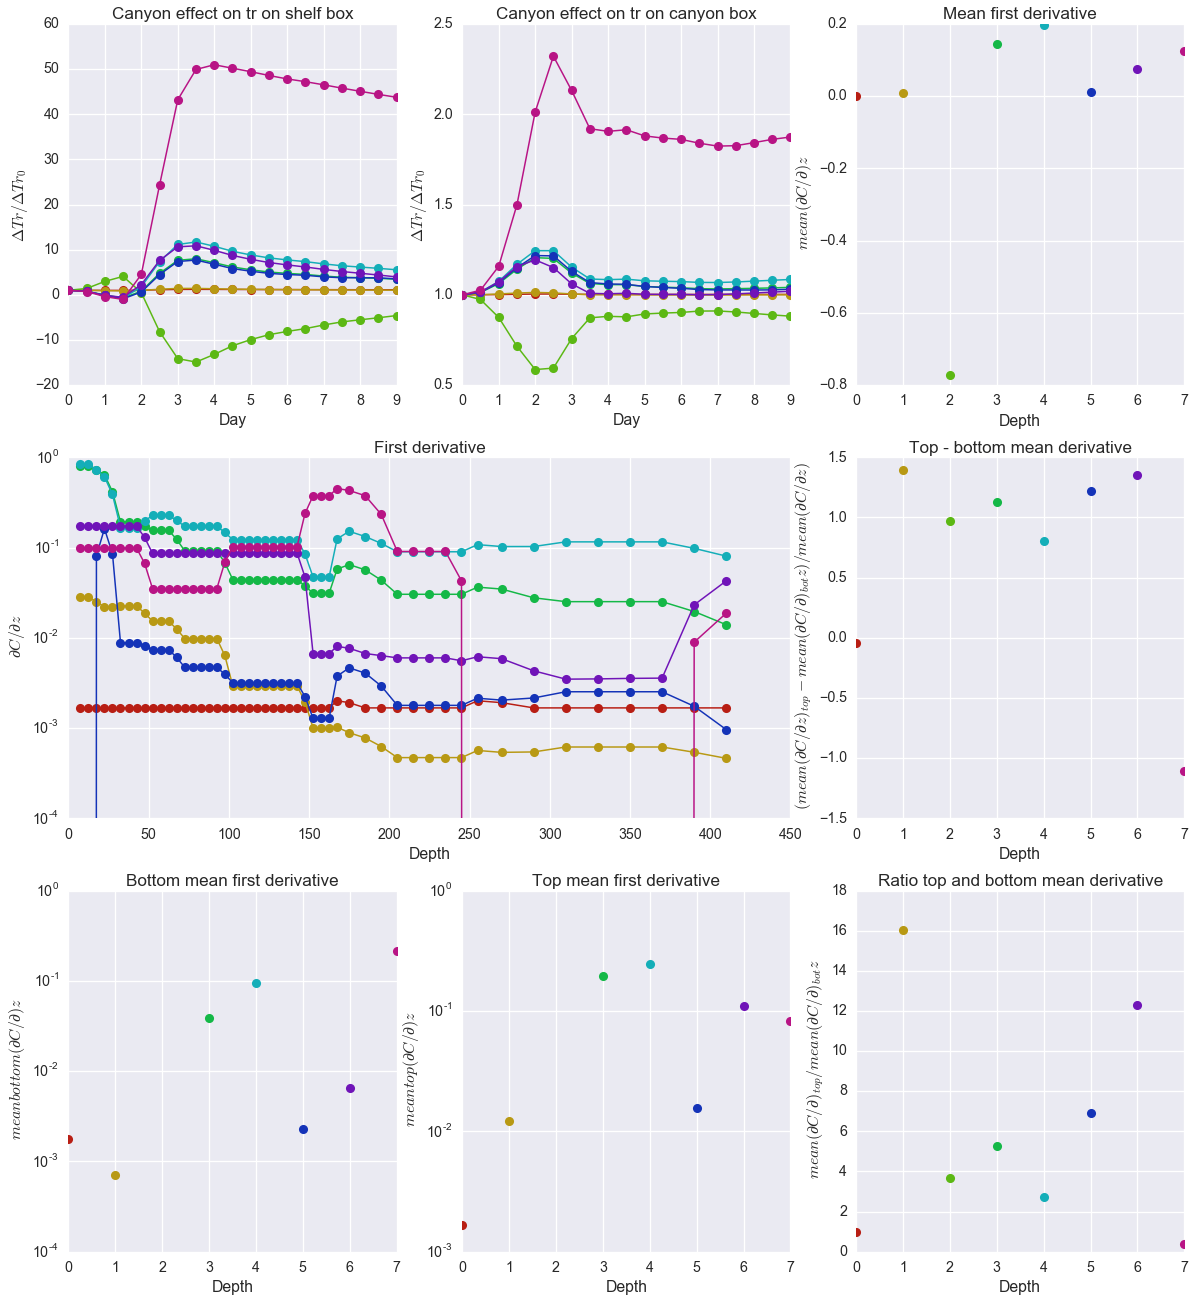

In [19]:
fig45=plt.figure(figsize=(20,22))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1.1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

sns.set_palette( sns.hls_palette(8, l=.4, s=.8))  

der = np.zeros((88,numTr))
secder = np.zeros((88,numTr))

for t in np.arange(0,numTr,1):
    der[:,t] = (IniP[2:,t] - IniP[:-2,t])/(drC[1:-2]+drC[2:-1]) 
#the first drc is 2.5 m, from surface to first cell center. drc's length is 91.
    secder[:,t] = (IniP[2:,t] -2.0*IniP[1:-1,t]+ IniP[:-2,t])/(drC[1:-2]*drC[2:-1]) 


for tr in range(numTr):
    
    ax1 = plt.subplot(3,3,1)
    ax1.plot(times/2.0, (TotalTr[:,tr]-TotalTrNoC[:,tr])/(TotalTr[0,tr]-TotalTrNoC[0,tr]),'o-', label=labels[tr])
    plt.ylabel('$\Delta Tr/\Delta Tr_0$ ')
    plt.xlabel('Day')
    plt.title('Canyon effect on tr on shelf box')
    
    #ax2 = plt.subplot(3,3,4)
    #ax2.plot(times/2.0, (TotalHCW[:,tr]-TotalHCWNoC[:,tr])/(volShelfBox-volShelfBoxNoC),'o-', label=labels[tr])
    #plt.title('HCW  difference relative to initial vol difference')
    #plt.ylabel('$\Delta V_{HCW}/\Delta V$')
    #plt.xlabel('Day')

    ax2 = plt.subplot(3,3,2)
    ax2.plot(times/2.0, (TotalTrHole[:,tr]-TotalTrHoleNoC[:,tr])/(TotalTrHole[0,tr]-TotalTrHoleNoC[0,tr]),'o-', label=labels[tr])
    plt.ylabel('$\Delta Tr/\Delta Tr_0$ ')
    plt.xlabel('Day')
    plt.title('Canyon effect on tr on canyon box')

    #ax4 = plt.subplot(3,3,5)
    #ax4.plot(times/2.0, (TotalHCWHole[:,tr]-TotalHCWHoleNoC[:,tr])/(volHoleBox-volHoleBoxNoC),'o-', label=labels[tr])
    #plt.title('HCW  difference relative to initial vol difference')
    #plt.ylabel('$\Delta V_{HCW}/\Delta V$')
    #plt.xlabel('Day')

    ax4 = plt.subplot(3,3,(4,5))
    ax4.plot(-rc[1:51], der[:50,tr] ,'o-', label=labels[tr])
    plt.ylabel(' $\partial C/\partial z$')
    ax4.set_yscale('log')
    plt.xlabel('Depth')
    plt.title('First derivative') 
    
    ax7 = plt.subplot(3,3,7)
    ax7.plot(tr, np.mean(der[29:43,tr]) ,'o-', label=labels[tr])
    plt.ylabel(' $ mean bottom (\partial C/\partial) z$')
    ax7.set_yscale('log')
    plt.xlabel('Depth')
    plt.title('Bottom mean first derivative')
    
    ax8 = plt.subplot(3,3,8)
    ax8.plot(tr, np.mean(der[0:29,tr]) ,'o-', label=labels[tr])
    plt.ylabel(' $ mean top (\partial C/\partial) z$')
    ax8.set_yscale('log')
    plt.xlabel('Depth')
    plt.title('Top mean first derivative')
    
    
    ax3 = plt.subplot(3,3,3)
    ax3.plot(tr, np.mean(der[:43,tr]) ,'o-', label=labels[tr])
    plt.ylabel(' $ mean (\partial C/\partial) z$')
    #ax7.set_yscale('log')
    plt.xlabel('Depth')
    plt.title('Mean first derivative')
    
    ax9 = plt.subplot(3,3,9)
    ax9.plot(tr, np.mean(der[0:28,tr])/np.mean(der[28:43,tr]) ,'o-', label=labels[tr])
    plt.ylabel(' $ mean (\partial C/\partial)_{top}/ mean(\partial C/\partial)_{bot} z$')
    #ax7.set_yscale('log')
    plt.xlabel('Depth')
    plt.title('Ratio top and bottom mean derivative')
    
    ax6 = plt.subplot(3,3,6)
    ax6.plot(tr, (np.mean(der[0:28,tr])-np.mean(der[28:43,tr]))/(np.mean(der[:43,tr])) ,'o-', label=labels[tr])
    plt.ylabel(' $ (mean (\partial C/\partial z)_{top}- mean(\partial C/\partial)_{bot} z)/mean(\partial C/\partial z)$')
    #ax7.set_yscale('log')
    plt.xlabel('Depth')
    plt.title('Top - bottom mean derivative')
    
    
        
#plt.tight_layout()

handles, labels = ax5.get_legend_handles_labels()
ax5.legend(handles, labels,loc=0)



#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')


Note that in the derviative calculation there are two bumps for the linear profile, when it should be contant for all depths. These bumbs correspond to depths where the resolution changes (the first one from 5 to 10 m under the shelfbreak and the second from 10 m to 25 m at around 250 m.)

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


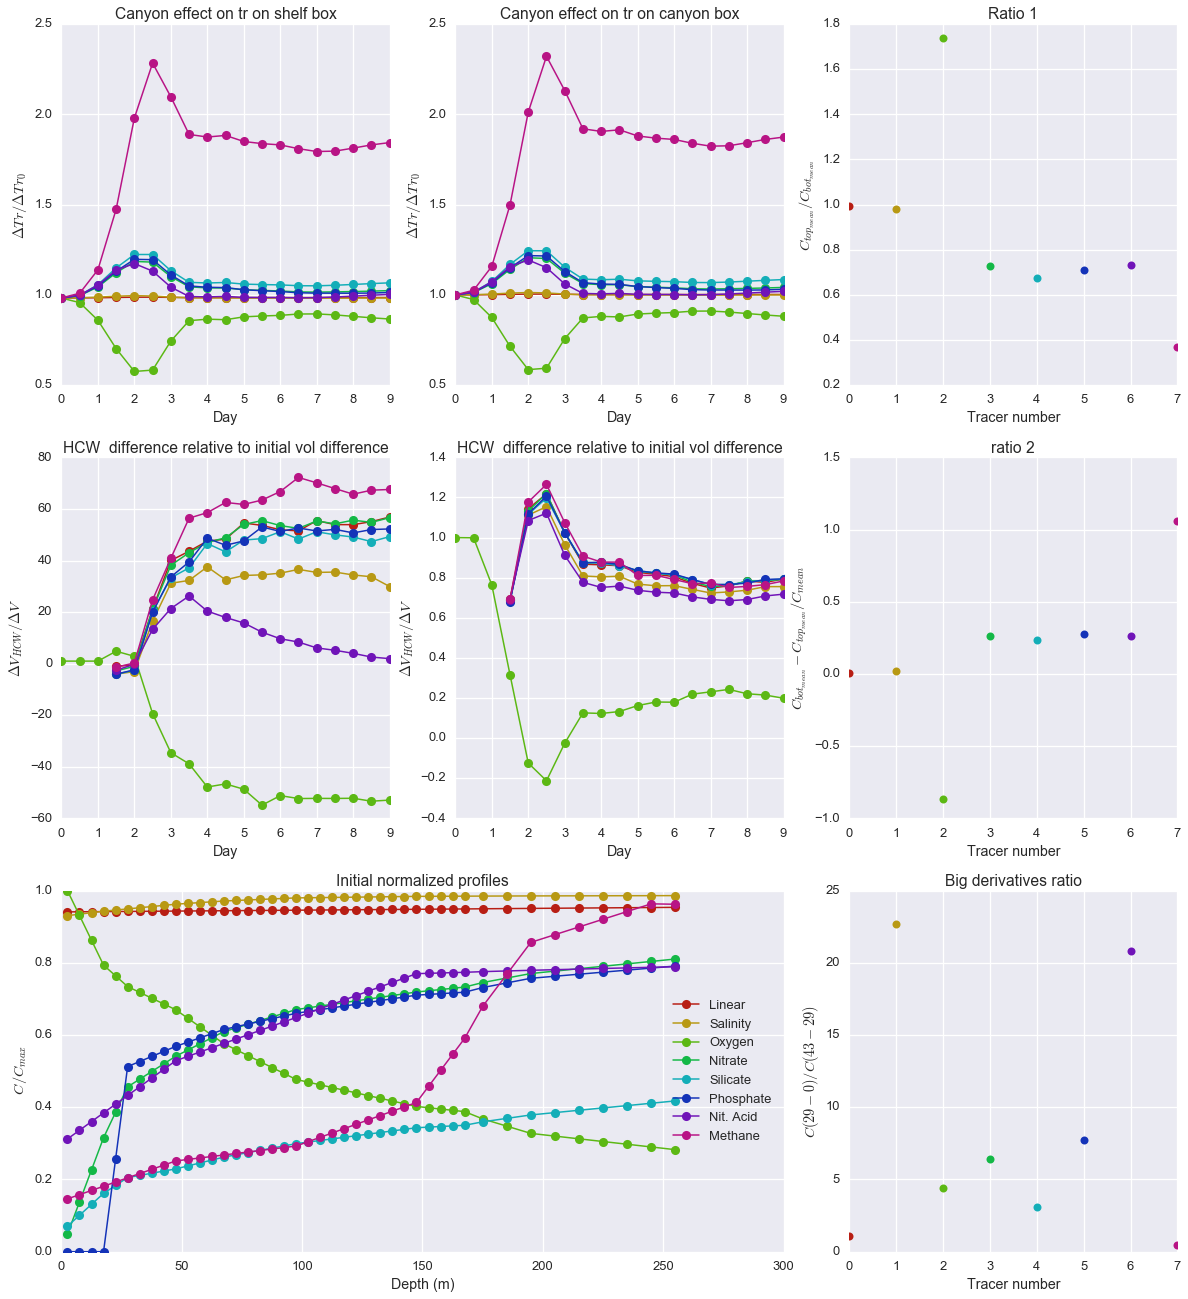